In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.layers import Reshape
from keras.models import Model
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.preprocessing.image import load_img, img_to_array
from keras.layers.core import Flatten
from keras.optimizers import SGD
from keras.datasets import mnist
import numpy as np
from PIL import Image
import argparse
import math

from keras.applications import VGG16, vgg16
from keras import backend as K
import keras
import matplotlib.pyplot as plt

# import mxnet as mx


Using Theano backend.


In [353]:
base_image_path = "ucsd.jpg"
style_reference_image_path = "vango.jpg"
# result_prefix = "res"
iterations = 30

total_variation_weight = 1.0
style_weight = 1.0 * 100
content_weight = 0.025 

width, height = load_img(base_image_path).size
img_nrows = 224
img_ncols = 224#int(width * img_nrows / height)

[ 0.44921875  0.48828125  0.73046875]
[ 0.39453125  0.51171875  0.796875  ]


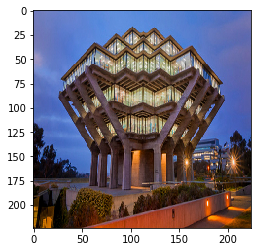

[ 0.04296875  0.09375     0.30078125]
[ 0.1640625   0.16015625  0.21484375]


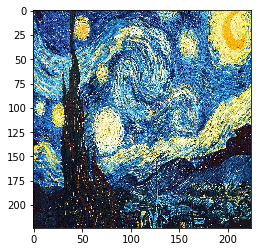

In [641]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img) * 1.0
    img = np.expand_dims(img, axis=0) / 256
    print img [0][0][0]
#     img = vgg16.preprocess_input(img) 
    print img [0][0][40]
    plt.imshow(img[0]  )
    plt.show()
    return img


def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_reference_image_path))

combination_image = K.placeholder((1, img_nrows, img_ncols, 3))



In [634]:
# input_tensor = K.concatenate([base_image,
#                               style_reference_image,
#                               combination_image], axis=0)

# model = vgg16.VGG16(input_tensor=input_tensor,
#                     weights='imagenet', include_top=False)
# print('Model loaded.')

# # get the symbolic outputs of each "key" layer (we gave them unique names).
# outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])



In [635]:
def gram_matrix(x):
    assert K.ndim(x) == 3
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
#     features = K.batch_flatten(K.permute_dimensions(x, (0, 1, 2)))


    gram = K.dot(features, K.transpose(features))
    return gram

# the "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image


def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    sLoss = K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))
#     print sLoss.eval()
    return sLoss

# an auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image


def content_loss(base, combination):
    return K.sum(K.square(combination - base))

# the 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent

def total_variation_loss(x):
    assert K.ndim(x) == 4
    a = K.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
    b = K.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))



In [636]:
# # combine these loss functions into a single scalar
# loss = K.variable(0.)
# layer_features = outputs_dict['block4_conv2']
# base_image_features = layer_features[0, :, :, :]
# combination_features = layer_features[2, :, :, :]
# loss += content_weight * content_loss(base_image_features,
#                                       combination_features)

# feature_layers = ['block1_conv1', 'block2_conv1',
#                   'block3_conv1', 'block4_conv1',
#                   'block5_conv1']
# for layer_name in feature_layers:
#     layer_features = outputs_dict[layer_name]
#     style_reference_features = layer_features[1, :, :, :]
#     combination_features = layer_features[2, :, :, :]
#     sl = style_loss(style_reference_features, combination_features)
#     loss += (style_weight / len(feature_layers)) * sl
# loss += total_variation_weight * total_variation_loss(combination_image)

# grads = K.gradients(loss, combination_image)

# outputs = [loss]
# # if isinstance(grads, (list, tuple)):
# #     outputs += grads
# # else:
# #     outputs.append(grads)

# f_outputs = K.function([combination_image], outputs)




In [637]:
# # combine these loss functions into a single scalar
# loss = K.variable(0.)
# layer_features = outputs_dict['block4_conv2']
# base_image_features = layer_features[0, :, :, :]
# combination_features = layer_features[2, :, :, :]
# loss += content_weight * content_loss(base_image_features,
#                                       combination_features)

# feature_layers = ['block1_conv1', 'block2_conv1',
#                   'block3_conv1', 'block4_conv1',
#                   'block5_conv1']
# for layer_name in feature_layers:
#     layer_features = outputs_dict[layer_name]
#     style_reference_features = layer_features[1, :, :, :]
#     combination_features = layer_features[2, :, :, :]
#     sl = style_loss(style_reference_features, combination_features)
#     loss += (style_weight / len(feature_layers)) * sl
# loss += total_variation_weight * total_variation_loss(combination_image)

# # grads = K.gradients(loss, combination_image)

# outputs = [loss]
# # if isinstance(grads, (list, tuple)):
# #     outputs += grads
# # else:
# #     outputs.append(grads)

# f_outputs = K.function([combination_image], outputs)




In [638]:
# base_image_path = "vango2.jpg"
# style_reference_image_path = "vango2.jpg"
# # result_prefix = "res"
# iterations = 30

# total_variation_weight = 1.0
# style_weight = 1.0
# content_weight = 0.025 

# width, height = load_img(base_image_path).size
# img_nrows = 224
# img_ncols = 224#int(width * img_nrows / height)

In [639]:
# def preprocess_image(image_path):
#     img = load_img(image_path, target_size=(img_nrows, img_ncols))
#     img = img_to_array(img)
#     img = np.expand_dims(img, axis=0)
#     img = vgg16.preprocess_input(img) / 256
#     return img

# base_image = K.variable(preprocess_image(base_image_path))
# style_reference_image = K.variable(preprocess_image(style_reference_image_path))

# combination_image = K.placeholder((1, img_nrows, img_ncols, 3))



In [640]:
# input_tensor = K.concatenate([base_image,
#                               style_reference_image,
#                               combination_image], axis=0)

# model1 = vgg16.VGG16(input_tensor=input_tensor,
#                     weights='imagenet', include_top=False)
# print('Model loaded.')

# # get the symbolic outputs of each "key" layer (we gave them unique names).
# outputs_dict = dict([(layer.name, layer.output) for layer in model1.layers])



In [655]:
# def get_loss(y_true, y_pred):
# #     print "yT", y_true
# #     print "yP", y_pred
#     loss = style_loss(y_true[0, :, :, :], y_pred[0, :, :, :])
# #     loss += 0.25 * content_loss(base_image[0, :, :, :], y_pred[0, :, :, :])
#     print "loss", K.shape(loss), loss
#     return loss

def get_loss2(y_true, y_pred):
    sty = (style_reference_image)
#     combo0 =  y_pred[:, :, :, 0] * 256 - 103.939
#     combo1 =  y_pred[:, :, :, 1] * 256 - 116.779
#     combo2 =  y_pred[:, :, :, 2] * 256 - 103.939
    
#     combo = K.concatenate([combo0,
#                             combo1,
#                             combo2], axis=0)
#     combo = K.permute_dimensions(combo, (1, 2, 0))
    
#     combo = K.expand_dims(combo, 0)
    combo = y_pred
#     print combo.shape.eval(), sty.shape.eval()
#     combo = vgg16.preprocess_input(combo)
    base = (base_image)
#     loss = style_loss(sty[0, :, :, :], combo[0, :, :, :])
#     loss += 0.25 * content_loss(base[0, :, :, :], combo[0, :, :, :])
#     print "loss", K.shape(loss), loss
    input_tensor = K.concatenate([base,
                                  sty,
                                  combo], axis=0)

    model = vgg16.VGG16(input_tensor=input_tensor,
                        weights='imagenet', include_top=False)
    print('Model loaded.')

    # get the symbolic outputs of each "key" layer (we gave them unique names).
    outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

    loss = K.variable(0.)
    layer_features = outputs_dict['block4_conv2']
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = content_weight * content_loss(base_image_features,
                                          combination_features)
#     print loss
    feature_layers = ['block1_conv1', 'block2_conv1',
                      'block3_conv1', 'block4_conv1',
                      'block5_conv1']
#     for layer_name in feature_layers:
#         layer_features = outputs_dict[layer_name]
#         style_reference_features = layer_features[1, :, :, :]
#         combination_features = layer_features[2, :, :, :]
#         sl = style_loss(style_reference_features, combination_features)
#         loss += (style_weight / len(feature_layers)) * sl
#     print loss,
    loss += total_variation_weight * total_variation_loss(combo)
#     print loss,
    return loss 



# def mean_squared_error(y_true, y_pred):
#     return K.mean(K.square(y_pred - y_true), axis=-1)


# def my_loss(y_true, y_pred):
#     model1 = vgg16.VGG16(weights='imagenet', include_top=False)
#     print type(y_true), y_true
#     out_true = model1.predict(y_true)
#     out_pred = model1.predict(y_pred)
# #     return K.variable(0.)
#     return get_loss(out_true, out_pred)

def my_loss_2(y_true, y_pred):
#     print type(y_pred.eval())
    print y_pred.eval()
    outs = f_outputs([y_pred])
    loss_value = outs[0]
    return loss_value


# def get_actual_loss(y_true, y_pred):
# #     return mean_squared_error(y_true, y_pred)

# #     img11 = vgg16.preprocess_input(y_pred)
#     combination_image = y_pred#K.variable(img11)
#     style_reference_image = y_true
# #     base_image = K.variable(preprocess_image(base_image_path))
    
#     input_tensor = K.concatenate([base_image,
#                               style_reference_image,
#                               combination_image], axis=0)

#     model1 = vgg16.VGG16(input_tensor=input_tensor,
#                         weights='imagenet', include_top=False)
# #     print('Model loaded.')

#     # get the symbolic outputs of each "key" layer (we gave them unique names).
#     outputs_dict = dict([(layer.name, layer.output) for layer in model1.layers])

    
#     loss = K.variable(0.)
#     layer_features = outputs_dict['block4_conv2']
#     base_image_features = layer_features[0, :, :, :]
#     combination_features = layer_features[2, :, :, :]
#     loss += content_weight * content_loss(base_image_features,
#                                           combination_features)
#     return loss
# #     feature_layers = ['block1_conv1', 'block2_conv1',
# #                       'block3_conv1', 'block4_conv1',
# #                       'block5_conv1']
# #     for layer_name in feature_layers:
# #         layer_features = outputs_dict[layer_name]
# #         style_reference_features = layer_features[1, :, :, :]
# #         combination_features = layer_features[2, :, :, :]
# #         sl = style_loss(style_reference_features, combination_features)
# #         loss += (style_weight / len(feature_layers)) * sl
# #     loss += total_variation_weight * total_variation_loss(combination_image)
# #     return loss
# #     outputs = [loss]

# #     f_outputs = K.function([combination_image], outputs)
# #     outs = f_outputs([combination_image])
# #     loss_value = outs[0]
# #     return loss_value



In [656]:
# print type(inpY)
# print get_loss2(base_image, base_image)
# base_image.eval()
print np.min(base_image[:, :, :, 1].eval()), np.max(base_image[:, :, :, 1].eval())

0.0 0.992188


In [657]:
# Combine generative layer with VGG layer
inputs = Input(shape=( 224*224*3, ))
inputs_ = Input(shape=( 224,224,3, ))


# Layer 1
x1 = Dense(5, activation = 'tanh', init = 'glorot_uniform')(inputs)

# Layer 2
x = Dense(64*56*56, activation = 'tanh', init = 'glorot_uniform')(x1)
x = BatchNormalization()(x)
# x = Reshape((16, 7, 7))(x)
x = Reshape((56, 56, 64))(x)

# Layer 3
x = UpSampling2D(size = (2, 2), dim_ordering = 'tf')(x) 
x = Convolution2D(16, 5, 5, border_mode = 'same', activation = 'tanh')(x)

# # Layer 4
# x = UpSampling2D(size = (2, 2))(x) #shape is (16, 28, 28)
# x = Convolution2D(32, 5, 5, border_mode = 'same', activation = 'tanh')(x)

# # Layer 5
# x = UpSampling2D(size = (4, 4))(x) #shape is (16, 112, 112)
# x = Convolution2D(32, 5, 5, border_mode = 'same', activation = 'tanh')(x)

# Layer 6
x = UpSampling2D(size = (2, 2))(x) 
out = Convolution2D(3, 5, 5, border_mode = 'same', activation = 'sigmoid')(x)


#  output shape is (None, 3, 224, 224)
generative_model = Model(input = inputs, output = out)

# vgg_model = VGG16(weights = 'imagenet', include_top = False)
# for layer in vgg_model.layers:
#     layer.trainable = False
# outp_vgg = vgg_model.output

# # Discriminative model
# disc_model = Model(input = vgg_model.input, output = vgg_model.layers[8].output)

In [658]:
# model = Sequential()
# model.add(generative_model)
# model.add(disc_model)
generative_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_134 (InputLayer)           (None, 150528)        0                                            
____________________________________________________________________________________________________
dense_87 (Dense)                 (None, 5)             752645      input_134[0][0]                  
____________________________________________________________________________________________________
dense_88 (Dense)                 (None, 200704)        1204224     dense_87[0][0]                   
____________________________________________________________________________________________________
batchnormalization_44 (BatchNorm (None, 200704)        802816      dense_88[0][0]                   
___________________________________________________________________________________________

In [659]:
jpgfile = Image.open("vango2.jpg")
inp = np.array(jpgfile.getdata())
# img = inp
# print img.shape
# # img = img.swapaxes(0, 2)#.swapaxes(0, 1)
# plt.imshow(img )
# plt.show()



# inp = inp.swapaxes(0, 1)
print "basic", inp.shape
inpY = 1.0 * np.reshape(inp, (1,224, 224, 3)) 
# trainY = disc_model.predict([inp])
# trainY2 = disc_model.predict([inp * 1.0/256])
# print trainY2.shape

# import Image
jpgfile = Image.open("vango2.jpg")
inp = np.array(jpgfile.getdata())
# inp = inp.swapaxes(0, 1)
trainX = np.reshape(inp, (1, 224, 224, 3))
# trainX = disc_model.predict([inp])

trainX2 = np.reshape(trainX, (1, np.product(trainX.shape)))

trainX3 = trainX2 * 1.0/256

# trainX3 = trainX * 1.0/256


inpY = inpY*1.0 / 256
print trainX3.shape
print inpY.shape

basic (50176, 3)
(1, 150528)
(1, 224, 224, 3)


In [660]:
# print trainX3
# print ""
# print inpY
# generative_model.summary()

In [661]:
# import keras
# adam_op = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
# # sgd = SGD(lr=5, momentum=0.9, nesterov=True)
# model.compile(loss = get_loss
#               , optimizer = adam_op)

In [662]:
# model.fit(trainX3, trainY2, nb_epoch = 0)
# # generative_model.summary()

In [663]:
adam_op = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
generative_model.compile(
                loss = get_loss2,
#                 loss = my_loss_2,
              optimizer = adam_op)
# print trainX3.shape, inpY.shape


Model loaded.


Epoch 1/5
1/1 [==============================] - 4s - loss: 160594.8438
Epoch 2/5
1/1 [==============================] - 4s - loss: 160224.4844
Epoch 3/5
1/1 [==============================] - 4s - loss: 159725.2656
Epoch 4/5
1/1 [==============================] - 3s - loss: 159128.7500
Epoch 5/5
1/1 [==============================] - 3s - loss: 158540.1094
(224, 224, 3)


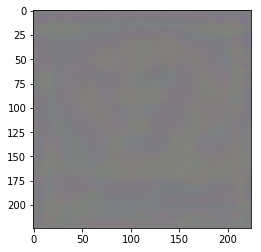

Epoch 1/5
1/1 [==============================] - 3s - loss: 157991.0938
Epoch 2/5
1/1 [==============================] - 3s - loss: 157372.7812
Epoch 3/5
1/1 [==============================] - 3s - loss: 156555.1875
Epoch 4/5
1/1 [==============================] - 4s - loss: 155470.6406
Epoch 5/5
1/1 [==============================] - 4s - loss: 154016.8594
(224, 224, 3)


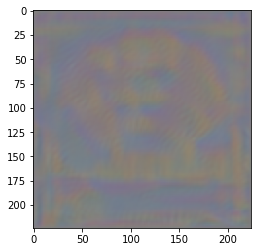

Epoch 1/5
1/1 [==============================] - 3s - loss: 152015.3750
Epoch 2/5
1/1 [==============================] - 3s - loss: 149269.5625
Epoch 3/5
1/1 [==============================] - 3s - loss: 145581.5312
Epoch 4/5
1/1 [==============================] - 3s - loss: 140773.9062
Epoch 5/5
1/1 [==============================] - 4s - loss: 134943.7188
(224, 224, 3)


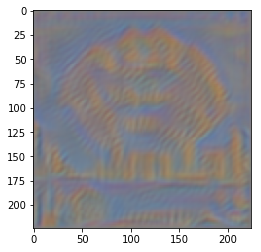

Epoch 1/5
1/1 [==============================] - 3s - loss: 128410.4766
Epoch 2/5
1/1 [==============================] - 4s - loss: 121434.5625
Epoch 3/5
1/1 [==============================] - 4s - loss: 114322.3906
Epoch 4/5
1/1 [==============================] - 4s - loss: 107298.1172
Epoch 5/5
1/1 [==============================] - 3s - loss: 100439.1953
(224, 224, 3)


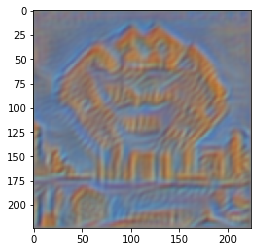

Epoch 1/5
1/1 [==============================] - 3s - loss: 93816.0625
Epoch 2/5
1/1 [==============================] - 3s - loss: 87555.0312
Epoch 3/5
1/1 [==============================] - 4s - loss: 81833.3906
Epoch 4/5
1/1 [==============================] - 3s - loss: 76895.4609
Epoch 5/5
1/1 [==============================] - 4s - loss: 72845.0078
(224, 224, 3)


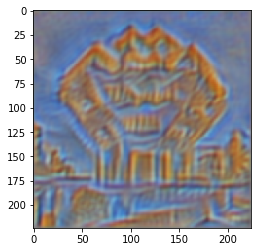

Epoch 1/5
1/1 [==============================] - 4s - loss: 69527.8438
Epoch 2/5
1/1 [==============================] - 4s - loss: 66438.7344
Epoch 3/5
1/1 [==============================] - 3s - loss: 63378.9570
Epoch 4/5
1/1 [==============================] - 3s - loss: 60357.7812
Epoch 5/5
1/1 [==============================] - 3s - loss: 57481.4531
(224, 224, 3)


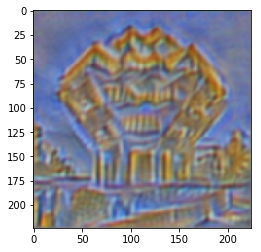

Epoch 1/5
1/1 [==============================] - 3s - loss: 54876.8477
Epoch 2/5
1/1 [==============================] - 3s - loss: 52570.0547
Epoch 3/5
1/1 [==============================] - 4s - loss: 50526.5781
Epoch 4/5
1/1 [==============================] - 3s - loss: 48647.0781
Epoch 5/5
1/1 [==============================] - 3s - loss: 46890.1211
(224, 224, 3)


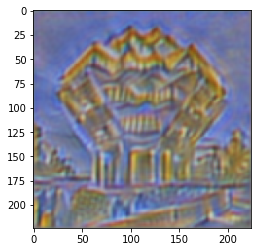

Epoch 1/5
1/1 [==============================] - 3s - loss: 45236.6875
Epoch 2/5
1/1 [==============================] - 3s - loss: 43680.8008
Epoch 3/5
1/1 [==============================] - 3s - loss: 42210.8750
Epoch 4/5
1/1 [==============================] - 3s - loss: 40823.4531
Epoch 5/5
1/1 [==============================] - 3s - loss: 39514.0469
(224, 224, 3)


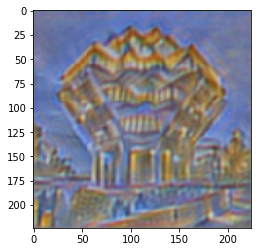

Epoch 1/5
1/1 [==============================] - 3s - loss: 38283.1172
Epoch 2/5
1/1 [==============================] - 3s - loss: 37124.4922
Epoch 3/5
1/1 [==============================] - 3s - loss: 36018.0430
Epoch 4/5
1/1 [==============================] - 3s - loss: 34969.4766
Epoch 5/5
1/1 [==============================] - 4s - loss: 33975.6641
(224, 224, 3)


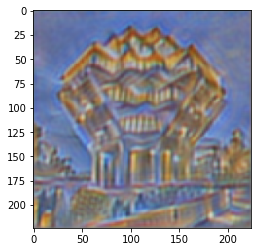

Epoch 1/5
1/1 [==============================] - 4s - loss: 33031.0039
Epoch 2/5
1/1 [==============================] - 3s - loss: 32118.3730
Epoch 3/5
1/1 [==============================] - 3s - loss: 31253.7734
Epoch 4/5
1/1 [==============================] - 3s - loss: 30429.9062
Epoch 5/5
1/1 [==============================] - 3s - loss: 29646.7559
(224, 224, 3)


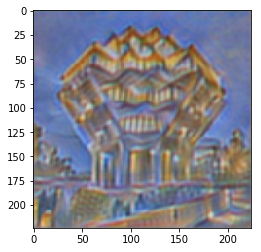

In [664]:
for i in range(10):
    generative_model.fit(trainX3, inpY, nb_epoch = 5)
    img = generative_model.predict(trainX3)
    img = img[0]
    print img.shape
    # img = img.swapaxes(0, 2)#.swapaxes(0, 1)
    plt.imshow(img)
    plt.show()

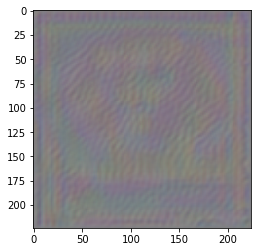

In [652]:
img = generative_model.predict(trainX3)
# img = base_image.eval()
img = img[0] #* 0.5 + 0.5
# img = img.swapaxes(0, 2)#.swapaxes(0, 1)
plt.imshow(img)
plt.show()


In [653]:
np.max(img[:, :, 2]), np.min(img[:, :, 2])

(0.56657022, 0.44180858)

In [654]:
print (style_reference_image*256 -128).eval()

[[[[-117. -104.  -51.]
   [-104. -100.  -39.]
   [-100. -109.  -82.]
   ..., 
   [  97.  119.   73.]
   [  85.   88.  -45.]
   [  72.   66.  -58.]]

  [[ -97.  -63.    0.]
   [ -93.  -75.   -9.]
   [ -95. -101.  -75.]
   ..., 
   [   7.   38.  105.]
   [  -6.   32.  -19.]
   [  68.   67.  -60.]]

  [[-119.  -57.    4.]
   [ -80.  -48.   13.]
   [ -78.  -84.  -58.]
   ..., 
   [ -78.  -45.  -74.]
   [ -99.  -37.  100.]
   [  -1.   43.   30.]]

  ..., 
  [[-100. -102.  -91.]
   [-106. -108.  -95.]
   [-100. -102.  -88.]
   ..., 
   [-100. -106.  -94.]
   [ -99. -105.  -95.]
   [-102. -107. -101.]]

  [[ -98. -106.  -95.]
   [-100. -106.  -94.]
   [-110. -111.  -95.]
   ..., 
   [ -94. -100.  -88.]
   [-101. -107.  -97.]
   [-100. -105.  -99.]]

  [[ -93. -109.  -98.]
   [ -98. -110.  -98.]
   [-107. -105.  -90.]
   ..., 
   [ -98. -104.  -92.]
   [-102. -108.  -98.]
   [-104. -109. -103.]]]]


In [599]:
img * 256

array([[[ 127.93692017,  134.32762146,  126.99884796],
        [ 126.74441528,  138.71740723,  125.82250214],
        [ 125.6470871 ,  142.52754211,  125.96897888],
        ..., 
        [ 127.82219696,  128.90846252,  127.48500824],
        [ 127.60630798,  128.30253601,  126.51018524],
        [ 127.41110992,  128.48251343,  126.88228607]],

       [[ 127.29879761,  136.86248779,  126.37042999],
        [ 126.04257202,  143.30931091,  125.44697571],
        [ 123.88368988,  149.06562805,  125.84687805],
        ..., 
        [ 127.7092514 ,  129.90124512,  128.37904358],
        [ 127.2230072 ,  128.6464386 ,  126.52893066],
        [ 127.15947723,  129.11172485,  126.84964752]],

       [[ 125.86302948,  139.6114502 ,  124.89925385],
        [ 125.14057159,  147.99893188,  124.697258  ],
        [ 122.69084167,  157.00473022,  124.38747406],
        ..., 
        [ 126.606987  ,  127.60422516,  129.48513794],
        [ 126.56939697,  126.55461884,  127.08721161],
        [ 127.09171